<div style="text-align: center">
    <img src="public/banner.png" width="600" alt="Banner" style="border-radius: 8px">
    <h1><strong>A study of Poles' psychedelic and non-psychedelic mystical experiences in relation to fear of death, emotional empathy, and life satisfaction</strong></h1>
</div>
<div style="text-align: center">
    <h3><strong>Part II: Lingustic analysis</strong></h1>
</div>

# **Imports**

## **Importing libraries**

In [52]:
import pandas as pd
import numpy as np
import requests
import warnings
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import STOPWORDS, WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from collections import Counter
from scipy.stats import pearsonr
from PIL import Image, ImageDraw
from transformers import pipeline

## **Loading dataset**

In [26]:
dataset_path = "public/dataset.xlsx"
df = pd.read_excel(dataset_path)

# **Data wrangling and cleaning**

## **Joining female and male variables into one dataframe**

In [27]:
columns_to_process = [col[:-2] for col in df.columns if col.endswith("_M")]
combined_columns = {}

for col in columns_to_process:
    male_col = f"{col}_M"
    female_col = f"{col}_F"
    
    if df[male_col].dtype == "float64" and df[female_col].dtype == "float64":
        male_variables = pd.to_numeric(df[male_col], errors="coerce").fillna(0)
        female_variables = pd.to_numeric(df[female_col], errors="coerce").fillna(0)
        
        combined_columns[col] = male_variables + female_variables
        
    elif df[male_col].dtype == "object" and df[female_col].dtype == "object":
        male_variables = df[male_col].fillna("")
        female_variables = df[female_col].fillna("")
        
        combined_columns[col] = male_variables + female_variables

combined_df = pd.DataFrame(combined_columns)

df = pd.concat([df, combined_df], axis=1)

df.drop(columns=[f"{col}_M" for col in columns_to_process] + [f"{col}_F" for col in columns_to_process], inplace=True)

pd.set_option("display.max_columns", None)
df.head()

,start_date,end_date,progress_in_percent,duration_in_seconds,finished,recorded_date,age,sex,survey_version,worldview,education,meditation,compound_never,compound_LSD,compound_psylocybin,compound_ayahuasca,compound_DMT,compound_5MeODMT,compound_mescaline,compound_ibogaine,compound_salvia,compound_other,compound_text,use_amount,microdose,low_dose,average_dose,high_dose,very_high_dose,mystical_experience,context_psychedelic,context_other_psychoactive,context_NDE,context_meditation,context_ritual,context_hypnosis,context_other,context_other_psychoactive_text,context_other_text,trigger_compound,order,intensity,how_long_ago,MEQ30_1,MEQ30_2,MEQ30_3,MEQ30_4,MEQ30_5,MEQ30_6,MEQ30_7,MEQ30_8,MEQ30_9,MEQ30_10,MEQ30_11,MEQ30_12,MEQ30_13,MEQ30_14,MEQ30_15,MEQ30_16,MEQ30_17,MEQ30_18,MEQ30_19,MEQ30_20,MEQ30_21,MEQ30_22,MEQ30_23,MEQ30_24,MEQ30_25,MEQ30_26,MEQ30_27,MEQ30_28,MEQ30_29,MEQ30_30,PES_1,PES_2,PES_3,PES_4,PES_5,PES_6,PES_7,PES_8,PES_9,PES_10,PES_11,SWLS_1,SWLS_2,SWLS_3,SWLS_4,SWLS_5,DAP_R_1,DAP_R_2,DAP_R_3,DAP_R_4,DAP_R_5,DAP_R_6,DAP_R_7,DAP_R_8,influence_empathy,influence_satisfaction,influence_fear,description_text
0,2023-02-17 22:50:49,2023-02-17 23:04:08,100,798,1,2023-02-17 23:04:09,28.0,1.0,1.0,2.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,6.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,,,2.0,0.0,0.0,4.0,6.0,6.0,6.0,6.0,6.0,4.0,5.0,5.0,5.0,6.0,5.0,4.0,6.0,5.0,5.0,5.0,4.0,6.0,5.0,5.0,5.0,6.0,5.0,4.0,4.0,5.0,5.0,5.0,6.0,5.0,4.0,4.0,2.0,5.0,2.0,4.0,3.0,3.0,4.0,4.0,2.0,3.0,4.0,2.0,1.0,3.0,5.0,6.0,7.0,5.0,6.0,7.0,7.0,5.0,2.0,2.0,2.0,
1,2023-02-18 00:24:48,2023-02-18 00:34:16,100,567,1,2023-02-18 00:34:18,30.0,1.0,1.0,4.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,2.0,5.0,3.0,2.0,2.0,3.0,4.0,2.0,1.0,5.0,4.0,4.0,3.0,4.0,3.0,1.0,2.0,3.0,1.0,4.0,4.0,2.0,0.0,0.0,0.0,
2,2023-02-18 12:57:58,2023-02-18 13:13:33,100,934,1,2023-02-18 13:13:33,25.0,2.0,2.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Haszysz,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Ciastko z haszyszem,,0.0,0.0,0.0,52.0,6.0,4.0,6.0,5.0,6.0,4.0,6.0,4.0,6.0,6.0,6.0,3.0,6.0,5.0,5.0,5.0,3.0,4.0,6.0,4.0,5.0,6.0,1.0,3.0,2.0,5.0,1.0,5.0,6.0,1.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,1.0,5.0,2.0,2.0,2.0,1.0,3.0,3.0,4.0,
3,2023-02-18 13:14:33,2023-02-18 13:18:33,100,239,1,2023-02-18 13:18:34,22.0,2.0,2.0,4.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,3.0,4.0,3.0,2.0,3.0,4.0,2.0,2.0,3.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,0.0,0.0,0.0,
4,2023-02-18 13:19:13,2023-02-18 13:26:12,100,419,1,2023-02-18 13:26:13,28.0,2.0,2.0,4.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,2.0,3.0,3.0,2.0,3.0,4.0,3.0,3.0,4.0,5.0,5.0,6.0,5.0,3.0,2.0,2.0,5.0,2.0,3.0,2.0,2.0,0.0,0.0,0.0,


## **Recoding MEQ30 scorings**

In [28]:
meq30_columns = [col for col in df.columns if col.startswith("MEQ30")]

replacement_mapping = {
    1: 0, 
    2: 1, 
    3: 2, 
    4: 3, 
    5: 4, 
    6: 5
}

df[meq30_columns] = df[meq30_columns].replace(replacement_mapping)

## **Summing the results and checking for complete mystical experiences**

In [29]:
MEQ30_subscales = {
    "Mystical": [4, 5, 6, 9, 14, 15, 16, 18, 20, 21, 23, 24, 25, 26, 28],
    "Positive Mood": [2, 8, 12, 17, 27, 30],
    "Transcendence": [1, 7, 11, 13, 19, 22],
    "Ineffability": [3, 10, 29]
}

for subscale, items in MEQ30_subscales.items():
    df.loc[:, subscale] = df[[f"MEQ30_{item}" for item in items]].sum(axis=1)
    
max_score = {
    "Mystical": len(MEQ30_subscales["Mystical"]) * 5,
    "Positive Mood": len(MEQ30_subscales["Positive Mood"]) * 5,
    "Transcendence": len(MEQ30_subscales["Transcendence"]) * 5,
    "Ineffability": len(MEQ30_subscales["Ineffability"]) * 5
}

df["MEQ_complete"] = (
    (df["Mystical"] / max_score["Mystical"] >= 0.6) &
    (df["Positive Mood"] / max_score["Positive Mood"] >= 0.6) &
    (df["Transcendence"] / max_score["Transcendence"] >= 0.6) &
    (df["Ineffability"] / max_score["Ineffability"] >= 0.6)
).astype(int)

df["MEQ_total_score"] = (
    df["Mystical"] +
    df["Positive Mood"] +
    df["Transcendence"] +
    df["Ineffability"]
)

df.iloc[:10, -6:]

,Mystical,Positive Mood,Transcendence,Ineffability,MEQ_complete,MEQ_total_score
0,60.0,23.0,27.0,15.0,1,125.0
1,0.0,0.0,0.0,0.0,0,0.0
2,50.0,10.0,30.0,15.0,0,105.0
3,0.0,0.0,0.0,0.0,0,0.0
4,0.0,0.0,0.0,0.0,0,0.0
5,15.0,14.0,6.0,3.0,0,38.0
6,62.0,26.0,27.0,13.0,1,128.0
7,0.0,0.0,0.0,0.0,0,0.0
8,0.0,0.0,0.0,0.0,0,0.0
9,0.0,0.0,0.0,0.0,0,0.0


## **Removing incomplete records from the dataset**

In [30]:
incomplete_survey = df[df["finished"] == 0]

df.drop(incomplete_survey.index, inplace=True)
df.reset_index(drop=True, inplace= True)

print(f"We are left with {df.shape[0]} completed surveys.")

We are left with 724 completed surveys.


## **Filtering records that include description of an experience**

In [31]:
df_desc = df[df["description_text"] != ""]
df_desc.reset_index(drop=True, inplace= True)

print(f"Out of these {df.shape[0]} records, {df_desc.shape[0]} participants decided to share a description.")

Out of these 724 records, 338 participants decided to share a description.


# **Translation**

## **Using DeepL REST API**

In [32]:
# def translate(description, target_lang="EN-US", api_key="API_KEY_PLACEHOLDER"):
#     url = "https://api.deepl.com/v2/translate"
#     params = {
#         "auth_key": api_key,
#         "text": description,
#         "target_lang": target_lang
#     }
#     response = requests.post(url, data=params)
#     result = response.json()
#     return result["translations"][0]["text"]

In [33]:
# polish_descriptions = df_desc["description_text"]

# english_descriptions = []

# for description in polish_descriptions:
#     try:
#         translated_description = translate(description)
#         english_descriptions.append(translated_description)
#     except Exception as e:
#         print(f"Error translating text: {description}, error: {e}")
#         english_descriptions.append(None)

# df_translated = df_desc.copy()
# df_translated["description_text_EN"] = english_descriptions

In [34]:
# df_translated.to_excel("public/dataset_with_english_descriptions.xlsx", index=False)

In [35]:
translated_dataset_path = "public/dataset_with_english_descriptions.xlsx"
df_english = pd.read_excel(translated_dataset_path)

pd.set_option("display.max_colwidth", 1000)
df_english[["description_text", "description_text_EN", "MEQ_total_score", "MEQ_complete"]].head(5)

,description_text,description_text_EN,MEQ_total_score,MEQ_complete
0,"Po ponad 72 godzinach bez snu w trakcie których zażywałem duże ilości mdma, psylocybiny oraz thc - gdy sen w końcu nadszedł, byłem podczas tego praktycznie sto procent świadomy - to ja decydowałem co będzie się działo dalej, podejmując decyzję wynikające z wewnętrznego dialogu. W pewnym momencie poczułem niesamowita błogość i ciepło i zobaczyłem siebie leżącego na łóżku obok mojej partnerki - widziałem siebie, z zaciekawieniem się sobie przyglądałem. To trwało jakieś 5 może 10 minut, podczas których płakałem i cieszyłem się jednocześnie. Zmieniło to moje życie w takim sensie, że zastanawiałem się a co jeśli będąc w takim stanie spotkam kogoś kto też w nim jest? Co się stanie? Czy będziemy mogli się porozumieć?","After more than 72 hours without sleep during which I took large amounts of mdma, psilocybin and thc - when sleep finally came, I was practically one hundred percent conscious during it - I was the one who decided what was going to happen next, making decisions resulting from the internal dialogue. At one point, I felt incredible bliss and warmth and saw myself lying on the bed next to my partner - I could see myself, curiously looking at myself. This went on for about 5 maybe 10 minutes, during which I cried and rejoiced at the same time. It changed my life in the sense that I wondered what if, being in this state, I meet someone who is also in it? What will happen? Will we be able to communicate?",119,1
1,Wyleczyło mnie z dolegliwości które lekarze bezskutecznie leczyli od 15 lat,It cured me of ailments that doctors had been treating for 15 years without success,130,1
2,"Doświadczenie miało miejsce 7 lat temu. Podczas jazdy małym busem bez świateł w środku słuchałam jakiegoś powolnego utworu. Zamknęłam oczy i położyłam głowę na oparciu. Podróż mogła trwać max 20 minut - dla mnie trwała pare godzin. Czułam jakbym ja była w muzyce, nie potrafie tego opisać. Wiedziałam, ze po otwarciu oczu mogłabym wcale już nie być w busie, było błogo, czułam się bezpiecznie, że unoszę się w powietrzu, a nie jestem w swoim ciele, byłam gdzieś daleko. Do teraz nie wiem jak to opisać, ani co to było. To doświadczenie na pewno zostanie ze mną do końca życia jako niesamowite i niewyjaśnione uniesienie.","The experience took place 7 years ago. While driving a small bus with no lights inside, I was listening to some slow song. I closed my eyes and laid my head on the backrest. The trip may have lasted 20 minutes max - for me it lasted a couple of hours. I felt like I was in the music, I can't describe it. I knew that after opening my eyes I might not be in the bus at all anymore, it was blissful, I felt safe, that I was floating in the air, not in my body, I was somewhere far away. To this day I don't know how to describe it or what it was. This experience will definitely stay with me for the rest of my life as an amazing and unexplained rapture.",92,0
3,"Wrazenie podrzymywania mnie jako osoby,które bylo we mnie ale nie ze mnie",Along with holding me up as a person that was in me but not of me,77,0
4,"jak to jest, że coś tak materialnego jak umysł może dać początek czemuś tak niematerialnemu jak doświadczenie?",How is it that something as material as the mind can give rise to something as immaterial as experience?,64,0


# **Data analysis**

## **Word frequency distribution analysis**

In [36]:
concatenated_descriptions = " ".join(df_english["description_text_EN"])

In [47]:
stopwords = set(STOPWORDS).union({"ve"})

tokens = word_tokenize(concatenated_descriptions.lower())

filtered_tokens = [
    word for word in tokens if 
    word.isalpha() and word not in stopwords
]

In [48]:
word_frequencies = Counter(filtered_tokens)
top_25_words = word_frequencies.most_common(25)

top_25_words

[('experience', 244),
 ('life', 168),
 ('felt', 135),
 ('time', 117),
 ('body', 80),
 ('everything', 75),
 ('one', 74),
 ('something', 66),
 ('feeling', 64),
 ('experienced', 64),
 ('experiences', 61),
 ('feel', 58),
 ('love', 57),
 ('world', 56),
 ('sense', 53),
 ('know', 50),
 ('state', 48),
 ('death', 48),
 ('saw', 43),
 ('first', 42),
 ('trip', 41),
 ('reality', 41),
 ('people', 40),
 ('able', 38),
 ('many', 38)]

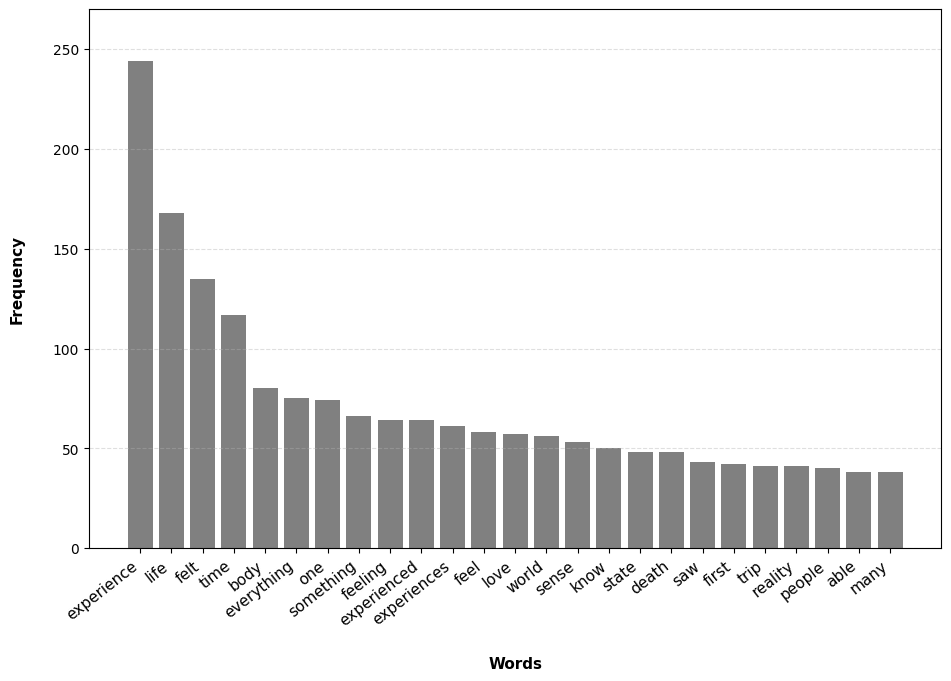

In [107]:
words, frequencies = zip(*top_25_words)

plt.figure(figsize=(11, 7))
plt.bar(words, frequencies, color="grey")
plt.xlabel("Words", fontweight="bold", fontsize=11, labelpad=20)
plt.ylabel("Frequency", fontweight="bold", fontsize=11, labelpad=20)
plt.xticks(rotation=38, ha="right", fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.ylim(0, 270)
plt.show()

## **Correlation analysis**

In [40]:
stopwords_list = list(stopwords)
warnings.filterwarnings("ignore")
    
vectorizer = CountVectorizer(stop_words=stopwords_list)
X = vectorizer.fit_transform(df_english["description_text_EN"])

word_features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

df_combined = pd.concat([df_english[["MEQ_total_score"]], word_features], axis=1)

df_combined.head(10)

MEQ_total_score  10  100  100th  11  12  14  15  150  15min  15th  16  17  \
0              119   1    0      0   0   0   0   0    0      0     0   0   0   
1              130   0    0      0   0   0   0   1    0      0     0   0   0   
2               92   0    0      0   0   0   0   0    0      0     0   0   0   
3               77   0    0      0   0   0   0   0    0      0     0   0   0   
4               64   0    0      0   0   0   0   0    0      0     0   0   0   
5               26   0    0      0   0   0   0   0    0      0     0   0   0   
6               94   0    0      0   0   0   0   0    0      0     0   0   0   
7              116   0    0      0   0   0   0   0    0      0     0   0   0   
8               74   0    0      0   0   0   0   0    0      0     0   0   0   
9              114   0    0      0   0   0   0   0    0      0     0   0   0   

   180  19  20  2019  2048  21  22  22r  24  25  250ug  26  27  2g  2nd  30  \
0    0   0   0     0     0   0   0    0   0   0      0   0   0   0    0   0   
1    0   0   0     0     0   0   0    0   0   0      0   0   0   0    0   0   
2    0   0   1     0     0   0   0    0   0   0      0   0   0   0    0   0   
3    0   0   0     0     0   0   0    0   0   0      0   0   0   0    0   0   
4    0   0   0     0     0   0   0    0   0   0      0   0   0   0    0   0   
5    0   0   0     0     0   0   0    0   0   0      0   0   0   0    0   0   
6    0   0   0     0     0   0   0    0   0   0      0   0   0   0    0   0   
7    0   0   0     0     0   0   0    0   0   0      0   0   0   0    0   0   
8    0   0   0     0     0   0   0    0   0   0      0   0   0   0    0   0   
9    0   0   0     0     0   0   0    0   0   0      0   0   0   0    0   0   

   33  36  360st  380  3rd  480  5m  6months  70g  72  75  80  abandoned  \
0   0   0      0    0    0    0   0        0    0   1   0   0          0   
1   0   0      0    0    0    0   0        0    0   0   0   0          0   
2   0   0      0    0    0    0   0        0    0   0   0   0          0   
3   0   0      0    0    0    0   0        0    0   0   0   0          0   
4   0   0      0    0    0    0   0        0    0   0   0   0          0   
5   0   0      0    0    0    0   0        0    0   0   0   0          0   
6   0   0      0    0    0    0   0        0    0   0   0   0          0   
7   0   0      0    0    0    0   0        0    0   0   0   0          0   
8   0   0      0    0    0    0   0        0    0   0   0   0          0   
9   0   0      0    0    0    0   0        0    0   0   0   0          0   

   abilities  ability  able  absence  absolute  absolutely  absorbing  \
0          0        0     1        0         0           0          0   
1          0        0     0        0         0           0          0   
2          0        0     0        0         0           0          0   
3          0        0     0        0         0           0          0   
4          0        0     0        0         0           0          0   
5          0        0     0        0         0           0          0   
6          0        0     1        0         0           0          0   
7          0        0     0        0         0           0          0   
8          0        0     0        0         0           0          0   
9          0        0     0        0         0           0          0   

   abstract  abundance  abuse  abusing  abusive  abyss  accent  accept  \
0         0          0      0        0        0      0       0       0   
1         0          0      0        0        0      0       0       0   
2         0          0      0        0        0      0       0       0   
3         0          0      0        0        0      0       0       0   
4         0          0      0        0        0      0       0       0   
5         0          0      0        0        0      0       0       0   
6         0          0      0        0        0      0       0       0   
7         0        

In [41]:
correlation_results = []

for col in word_features.columns:
    feature_data = df_combined[col]
    corr, p_value = pearsonr(df_combined["MEQ_total_score"].loc[feature_data.index], feature_data)
    
    if p_value < 0.05:
        correlation_results.append((col, corr, f"{p_value:.3f}"))

results_df = pd.DataFrame(correlation_results, columns=["Token", "Pearson's R", "p-Value"])

positive_R = results_df[results_df.apply(lambda x: x ["Pearson's R"] > 0, axis=1)]
negative_R = results_df[results_df.apply(lambda x: x ["Pearson's R"] < 0, axis=1)]

sorted_positive_R = positive_R.sort_values(by="Pearson's R", ascending=False)
sorted_negative_R = negative_R.sort_values(by="Pearson's R", ascending=True)

print(f"We've got {sorted_positive_R.shape[0]} words positively, and {sorted_negative_R.shape[0]} words negatively correlated with the MEQ30 scores.")

We've got 28 words positively, and 167 words negatively correlated with the MEQ30 scores.


In [42]:
sorted_positive_R.head(15)

,Token,Pearson's R,p-Value
82,infinite,0.145402,0.007
190,world,0.145324,0.007
42,died,0.143565,0.008
50,energy,0.136621,0.012
43,dimensions,0.132906,0.014
94,let,0.130614,0.016
76,heaven,0.128888,0.018
80,huge,0.128824,0.018
182,ve,0.128188,0.018
192,years,0.127133,0.019


In [43]:
sorted_negative_R.head(15)

,Token,Pearson's R,p-Value
60,frightened,-0.211096,0.000
26,communion,-0.204659,0.000
53,example,-0.196958,0.000
55,facts,-0.191172,0.000
14,bad,-0.180538,0.001
126,pleasant,-0.174426,0.001
166,tachycardia,-0.170210,0.002
180,unrealness,-0.170210,0.002
138,recommend,-0.167866,0.002
148,sensations,-0.163876,0.003


### **Visualizing the correlations as wordclouds**

In [44]:
width, height = 800, 500
ellipse_width = width * 0.85
ellipse_height = height * 0.9

mask = Image.new("L", (width, height), 255)
draw = ImageDraw.Draw(mask)

draw.ellipse(
    [(width // 2 - ellipse_width // 2, height // 2 - ellipse_height // 2),
     (width // 2 + ellipse_width // 2, height // 2 + ellipse_height // 2)],
    fill=0
)

mask.save("public/ellipse_mask.png")

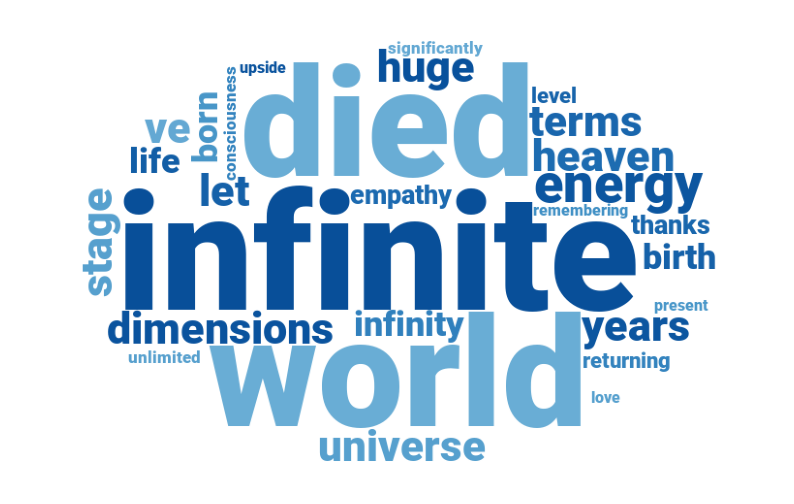

In [45]:
word_frequencies = dict(zip(sorted_positive_R["Token"], sorted_positive_R["Pearson's R"]))

blues = plt.cm.get_cmap("Blues")
start = 0.5
end = 0.9
edited_blues = LinearSegmentedColormap.from_list("new_blues", blues(np.linspace(start, end, 256)))

roboto_font = "public/fonts/Roboto/Roboto-Black.ttf"
mask_image = np.array(Image.open("public/ellipse_mask.png"))

wordcloud = WordCloud(
    width=800, 
    height=600,
    background_color="white",
    colormap=edited_blues,
    font_path=roboto_font,
    mask=mask_image
).generate_from_frequencies(word_frequencies)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

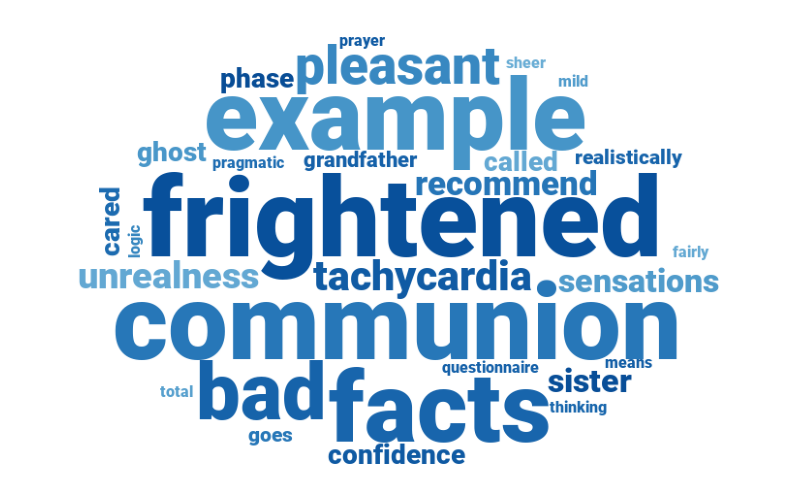

In [46]:
absolute_negative_R_values = sorted_negative_R["Pearson's R"].abs()

word_frequencies = dict(zip(sorted_negative_R["Token"], absolute_negative_R_values))
limited_word_frequencies = dict(list(word_frequencies.items())[:29])

blues = plt.cm.get_cmap("Blues")
start = 0.5
end = 0.9
edited_blues = LinearSegmentedColormap.from_list("new_blues", blues(np.linspace(start, end, 256)))

wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color="white",
    colormap=edited_blues,
    font_path=roboto_font,
    mask=mask_image
).generate_from_frequencies(limited_word_frequencies)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# **Emotional sentiment analysis**

## **Complete mystical experiences**

In [62]:
model_name = "arpanghoshal/EmoRoBERTa"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

filtered_df = df_english[df_english["MEQ_complete"] == 1]
descriptions = filtered_df["description_text_EN"].tolist()
sentiment_results = []

batch_size = 32

for i in range(0, len(descriptions), batch_size):
    batch = descriptions[i:i + batch_size]
    results = sentiment_pipeline(batch)
    sentiment_results.extend(results)

total_results = len(sentiment_results)
print(f"\nNumber of chunks analyzed: {total_results}\n")

for idx, result in enumerate(sentiment_results[:10]):
    print(f"Chunk {idx + 1}: {descriptions[idx]}")
    print(f"Emotion: {result["label"]}\nScore: {result["score"]:.3f}\n")


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.



Number of chunks analyzed: 152

Chunk 1: After more than 72 hours without sleep during which I took large amounts of mdma, psilocybin and thc - when sleep finally came, I was practically one hundred percent conscious during it - I was the one who decided what was going to happen next, making decisions resulting from the internal dialogue. At one point, I felt incredible bliss and warmth and saw myself lying on the bed next to my partner - I could see myself, curiously looking at myself. This went on for about 5 maybe 10 minutes, during which I cried and rejoiced at the same time. It changed my life in the sense that I wondered what if, being in this state, I meet someone who is also in it? What will happen? Will we be able to communicate?
Emotion: sadness
Score: 0.349

Chunk 2: It cured me of ailments that doctors had been treating for 15 years without success
Emotion: approval
Score: 0.790

Chunk 3: Trip like trip, dream like dream. Who would want to listen to that?
Emotion: confusio

In [89]:
unique_labels = set(result["label"] for result in sentiment_results)
label_counts = {label: 0 for label in unique_labels}

for result in sentiment_results:
    label_counts[result["label"]] += result["score"]

emotion_data = [(label, label_counts[label]) for label in unique_labels]
total_score = sum(label_counts.values())
percentage_data = [(label, (score / total_score) * 100) for label, score in emotion_data]

print("Aggregated emotion analysis results:\n")
for emotion, score in percentage_data:
    print(f"{emotion.capitalize()}: {score:.2f}%")

Aggregated emotion analysis results:

Realization: 23.90%
Fear: 4.34%
Sadness: 2.93%
Excitement: 1.17%
Disappointment: 0.70%
Optimism: 0.98%
Nervousness: 0.40%
Surprise: 3.15%
Amusement: 0.32%
Caring: 1.49%
Embarrassment: 0.53%
Love: 6.12%
Joy: 9.48%
Grief: 0.43%
Approval: 10.13%
Relief: 1.36%
Admiration: 15.49%
Desire: 0.55%
Neutral: 9.85%
Confusion: 1.11%
Gratitude: 5.57%


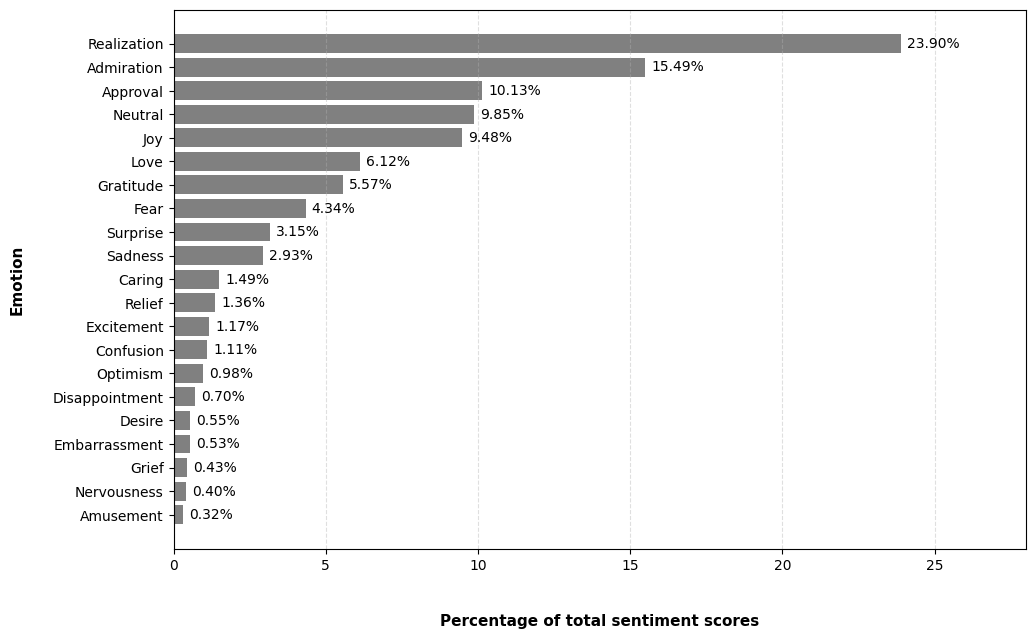

In [104]:
sorted_percentages = sorted(percentage_data, key=lambda x: x[1], reverse=False)

emotion_names = [emotion[0].capitalize() for emotion in sorted_percentages]
percentage_labels = [emotion[1] for emotion in sorted_percentages]

plt.figure(figsize=(11, 7))
bars = plt.barh(emotion_names, percentage_labels, color="gray")
for bar in bars:
    plt.text(
        bar.get_width() + 0.2,
        bar.get_y() + bar.get_height()/2,
        f"{bar.get_width():.2f}%",
        va="center", 
        fontsize=10
    )
plt.xlabel("Percentage of total sentiment scores", fontweight="bold", fontsize=11, labelpad=30)
plt.ylabel("Emotion", fontweight="bold", fontsize=11, labelpad=20)
plt.yticks(fontsize=10)
plt.xlim(0, 28)
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.show()

## **Non-complete mystical experiences**